In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits

In [2]:
Nside_jack = 4
def weight_nan_mean(value, weight):
    mean_val = np.zeros(value.shape[1])
    for i in range(len(mean_val)):
        idx = np.logical_not(np.isnan(value[:,i]))
        val = value[idx,i]
        wei = weight[idx,i]
        mean_val[i] = np.average(val, weights=wei)
    return mean_val

In [3]:
def load_data(file):
    if type(file) == str:
        file = open(file, 'rb')
    datas = []
    while True:
        try:
            datas.append(np.load(file))
        except EOFError:
            file.close()
            break
    return datas

def load_calculation_data(file):
    global r_p
    dat = load_data(file)
    if len(dat) == 1:
        return dat[0]
    elif len(dat) == 2:
        r_p = dat[0]
        return dat[1]

In [5]:
# dat = load_calculation_data('../calculation_data/result_r=3_100_15_quasar_lss_CMB_lcut_n_2048_tree.npy')
dat = load_calculation_data('../calculation_data/result_r=3_100_15_quasar_z>2_CMB_lcut_tree.npy')
dat_r = load_calculation_data('../calculation_data/result_r=3_100_15_random_quasar_lss_CMB_lcut_n_2048_tree.npy')

value = dat[0]
weight = dat[1]
value_r = dat_r[0]
weight_r = dat_r[1]

# quasar_cata = np.load('../catalogue/quasar_lss.npy')
quasar_cata = np.load('../catalogue/quasar_z>2.npy')
c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

print('finish loading quasar catalogue')

random_sample = np.load('../catalogue/random_quasar_lss.npy')
c = coo.SkyCoord(ra=random_sample['ra']*u.degree, dec=random_sample['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

print('finish loading random sample')

finish loading quasar catalogue
finish loading random sample


In [6]:
savefig = False

## quasar sample

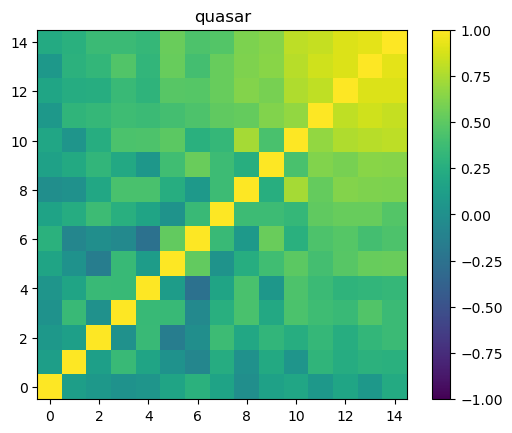

In [7]:
mean = weight_nan_mean(value, weight)
def jackknife_resample_q(i):
    idx = pix != i
    return weight_nan_mean(value[idx], weight[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_q, np.unique(pix))
jack_val_q = np.vstack(result)
cov_mat = np.cov(jack_val_q, ddof=0, rowvar=False)*(len(result)-1)
std = np.sqrt([cov_mat[i,i] for i in range(cov_mat.shape[0])])
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std[i]*std[j]
plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.colorbar()
plt.title('quasar')
if savefig:
    plt.savefig('./fig/cov_q')
plt.show()

## random sample

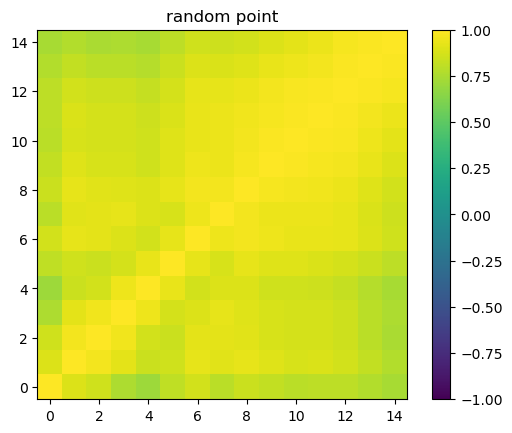

In [14]:
mean_r = weight_nan_mean(value_r, weight_r)
def jackknife_resample_r(i):
    idx = pix_r != i
    return weight_nan_mean(value_r[idx], weight_r[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_r, np.unique(pix_r))
jack_val_r = np.vstack(result)
cov_mat = np.cov(jack_val_r, ddof=0, rowvar=False)*(len(result)-1)
std_r = np.sqrt([cov_mat[i,i] for i in range(cov_mat.shape[0])])
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std_r[i]*std_r[j]
plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.title('random point')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_r')
plt.show()

## quasar - random

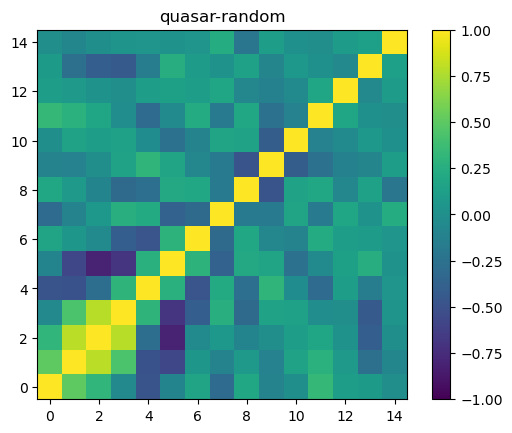

In [15]:
def jackknife_resample(i):
    idx = pix != i
    idx_r = pix_r != i
    return weight_nan_mean(value[idx], weight[idx])-weight_nan_mean(value_r[idx_r], weight_r[idx_r])
pro = mp.Pool(20)
result = pro.map(jackknife_resample, np.unique(pix))
jack_val = np.vstack(result)
cov_mat = np.cov(jack_val, ddof=0, rowvar=False)*(len(result)-1)
std_sub = np.sqrt([cov_mat[i,i] for i in range(cov_mat.shape[0])])
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std_sub[i]*std_sub[j]

plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.title('quasar-random')
plt.colorbar()
if savefig:
    plt.savefig('./fig/cov_qr')
plt.show()

## signal

In [16]:
np.savetxt('quasar_lss_sigma_2048', np.c_[r_p, mean-mean_r, std_sub])

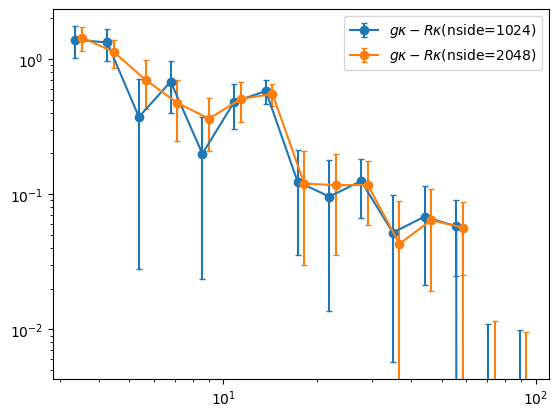

In [17]:
res_1024 = np.loadtxt('quasar_lss_sigma')
res_2048 = np.loadtxt('quasar_lss_sigma_2048')
r_p = res_1024[:,0]
plt.errorbar(r_p, res_1024[:,1], res_1024[:,2], capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$(nside=1024)')
plt.errorbar(r_p*1.05, res_2048[:,1], res_2048[:,2], capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$(nside=2048)')
plt.loglog()
plt.legend()

[]

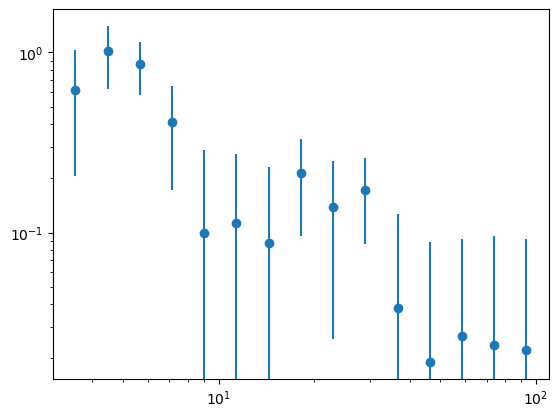

In [10]:
plt.errorbar(r_p*1.05, mean, std, fmt='o')
plt.loglog()

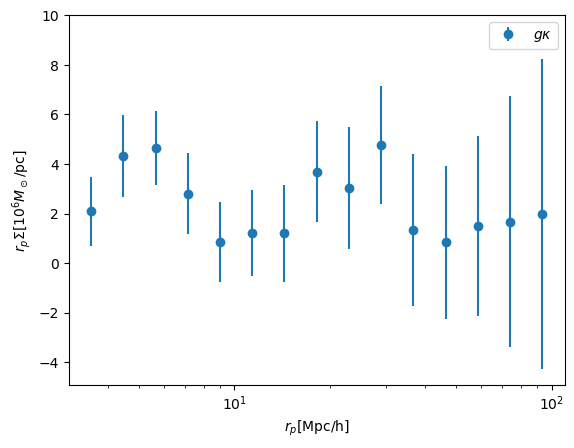

In [9]:
plt.errorbar(r_p*1.05, r_p*mean, r_p*std, label='$g\\kappa$', fmt='o')
plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
plt.ylim(top=10)
plt.legend()

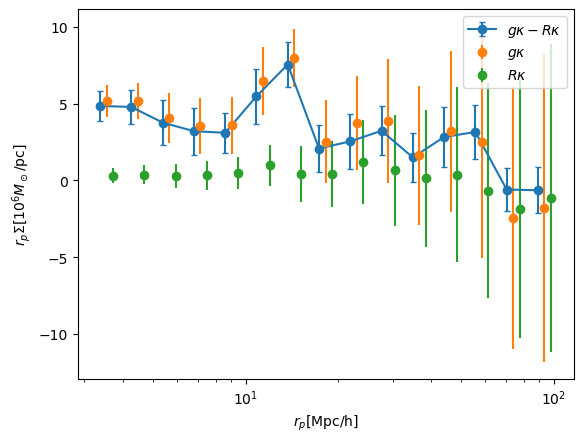

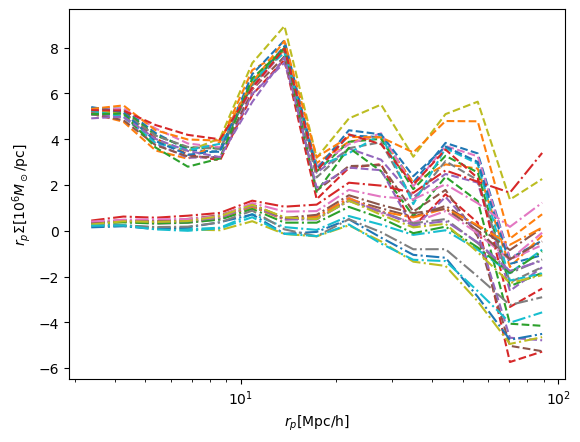

In [19]:
sig = mean-mean_r
plt.errorbar(r_p, r_p*sig, r_p*std_sub, capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$')
plt.errorbar(r_p*1.05, r_p*mean, r_p*std, label='$g\\kappa$', fmt='o')
plt.errorbar(r_p*1.05*1.05, r_p*mean_r, r_p*std_r, label='$R\\kappa$', fmt='o')
plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.ylim(top=50)
plt.legend()
if savefig:
    plt.savefig('./fig/quasar_random.jpg')
plt.show()

for i in range(jack_val_q.shape[1]):
    plt.plot(r_p, r_p*jack_val_q[i], '--')
for i in range(jack_val_r.shape[1]):
    plt.plot(r_p, r_p*jack_val_r[i], '-.')

plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')

if savefig:
    plt.savefig('./fig/quasar_random_jack.jpg')
plt.show()